In [23]:
%pip install requests pandas matplotlib seaborn

2220.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import requests
import json
from datetime import date
import pandas as pd

today = date.today().strftime('%Y-%m-%d')
url = f"https://api.nasdaq.com/api/quote/NDX/historical?assetclass=index&fromdate=1985-01-31&limit=9999&todate={today}&random=33"

headers = {
	'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, headers=headers)
data = response.json()

# Save to file
with open('ndx_historical.json', 'w') as f:
	json.dump(data, f, indent=2)

print("Data downloaded and saved to ndx_historical.json")

# the data structure is:
# {"data": {"symbol": "NDX", "totalRecords": 2517, "tradesTable": {"asOf": null, "headers": {"date": "Date", "close": "Close/Last", "volume": "Volume", "open": "Open", "high": "High", "low": "Low"}, "rows": [{"date": "06/27/2025", "close": "22,534.20", "volume": "--", "open": "22,484.87", "high": "22,603.22", "low": "22,382.79"}, {"date": "06/26/2025", "close": "22,447.29", "volume": "--", "open": "22,328.24", "high": "22,466.99", "low": "22,255.27"}]}}, "message": null, "status": {"rCode": 200, "bCodeMessage": null, "developerMessage": null}}

# convert the data to csv format
rows = data['data']['tradesTable']['rows']
df = pd.DataFrame(rows)
df.to_csv('ndx_historical.csv', index=False)
print('Data converted to DataFrame and saved to ndx_historical.csv')
print(f'Shape: {df.shape}')
print(df.head())


Data downloaded and saved to ndx_historical.json
Data converted to DataFrame and saved to ndx_historical.csv
Shape: (7491, 6)
         date      close volume       open       high        low
0  06/27/2025  22,534.20     --  22,484.87  22,603.22  22,382.79
1  06/26/2025  22,447.29     --  22,328.24  22,466.99  22,255.27
2  06/25/2025  22,237.74     --  22,279.69  22,329.23  22,175.08
3  06/24/2025  22,190.52     --  22,053.33  22,220.64  22,045.63
4  06/23/2025  21,856.33     --  21,632.78  21,871.87  21,532.32


In [25]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load the data
df = pd.read_csv('ndx_historical.csv')

# Data Cleaning and Preparation
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['close'] = df['close'].replace({',': ''}, regex=True).astype(float)
df = df.sort_values('date')

# Set the date as the index
df.set_index('date', inplace=True)

# Get the most recent date
latest_date = df.index.max()

# Function to calculate annualized return
def calculate_annualized_return(end_date, years):
    start_date_target = end_date - pd.DateOffset(years=years)
    
    # Find the closest available start and end dates in the data
    try:
        actual_start_date = df.index[df.index.searchsorted(start_date_target, side='left')]
        actual_end_date = df.index[df.index.searchsorted(end_date, side='right') - 1]
    except IndexError:
        return None, None, None # Not enough data

    start_price = df.loc[actual_start_date, 'close']
    end_price = df.loc[actual_end_date, 'close']
    
    # Handle cases where multiple rows might be returned for a date
    if isinstance(start_price, pd.Series):
        start_price = start_price.iloc[0]
    if isinstance(end_price, pd.Series):
        end_price = end_price.iloc[-1]

    # Calculate the number of years between the actual start and end dates
    actual_years = (actual_end_date - actual_start_date).days / 365.25
    
    if actual_years == 0:
        return 0.0, actual_start_date, actual_end_date

    # Calculate CAGR
    cagr = ((end_price / start_price) ** (1 / actual_years)) - 1
    return cagr * 100, actual_start_date, actual_end_date

# Calculate returns for different periods
periods = [1, 3, 5, 10, 20] 
max_years = (latest_date - df.index.min()).days / 365.25

results_list = []
for p in periods:
    if max_years >= p:
        cagr, start_date, end_date = calculate_annualized_return(latest_date, p)
        results_list.append({
            "Period": f"{p}-Year",
            "CAGR (%)": f"{cagr:.2f}",
            "Start Date": start_date.strftime('%Y-%m-%d'),
            "End Date": end_date.strftime('%Y-%m-%d')
        })
    else:
        results_list.append({
            "Period": f"{p}-Year",
            "CAGR (%)": "Not enough data",
            "Start Date": "-",
            "End Date": "-"
        })

# Calculate for the full period
cagr, start_date, end_date = calculate_annualized_return(latest_date, int(max_years))
results_list.append({
    "Period": f"Since Inception ({df.index.min().year})",
    "CAGR (%)": f"{cagr:.2f}",
    "Start Date": start_date.strftime('%Y-%m-%d'),
    "End Date": end_date.strftime('%Y-%m-%d')
})

# Create and display the DataFrame
results_df = pd.DataFrame(results_list)
display(results_df)


,Period,CAGR (%),Start Date,End Date
0,1-Year,13.88,2024-06-27,2025-06-27
1,3-Year,23.34,2022-06-27,2025-06-27
2,5-Year,17.76,2020-06-29,2025-06-27
3,10-Year,17.81,2015-06-29,2025-06-27
4,20-Year,14.53,2005-06-27,2025-06-27
5,Since Inception (1996),12.78,1996-06-27,2025-06-27


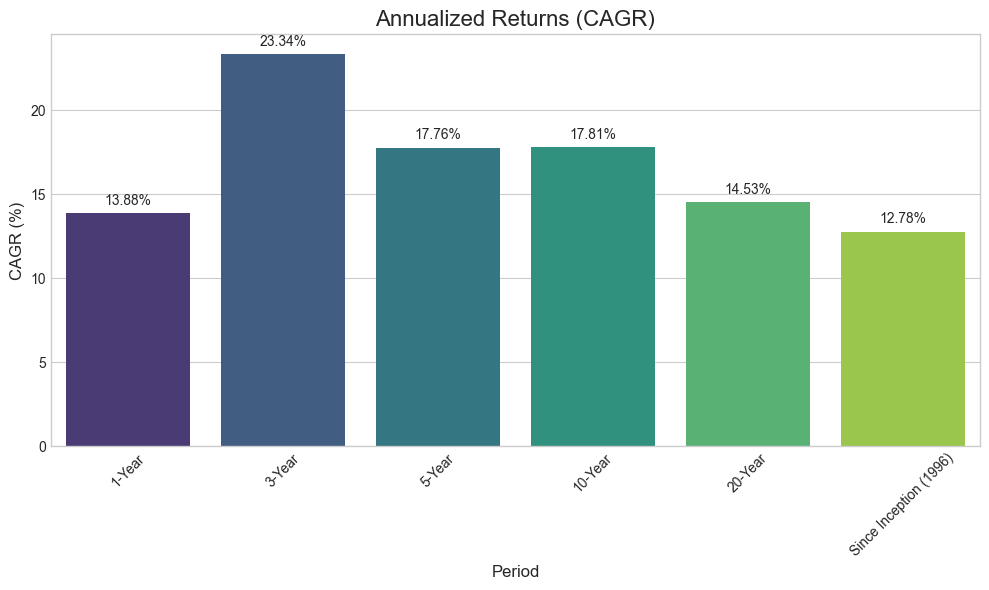

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
plot_df = results_df.copy()
plot_df['CAGR (%)'] = pd.to_numeric(plot_df['CAGR (%)'], errors='coerce')
plot_df.dropna(subset=['CAGR (%)'], inplace=True)

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='Period', y='CAGR (%)', data=plot_df, ax=ax, hue='Period', palette='viridis', legend=False)

ax.set_title('Annualized Returns (CAGR)', fontsize=16)
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('CAGR (%)', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 9), 
                  textcoords='offset points')

plt.tight_layout()
plt.show()
